In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline 
from scipy import interpolate
from scipy.signal import savgol_filter
import numpy as np
import pandas as pd
import math
import pims
import cv2
import skimage.filters as sk_fil
import imutils
import sys
import PIL
sys.path.insert(0, '/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/')

In [57]:
path = r'/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/Data/glass/Fused_Red_24-02-12_080-083/'
path_to_image_stackB = path + r'*.tif'
path_to_trajB = r'/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/Results_FINAL_glass/'

base = 'fig_sx_trajectories'
saveTrajFig = base+'.png'
saveTrajFig2 = base+'.tif'

In [32]:
def getSpeed2(x, y, dt,sparsity,trackEndB_x,trackEndB_y):
    spline_k = 3
    
    frame_ids = np.arange(0, len(x),1)           #create a x-axis array based on frames 
    frame_ids_sparse = np.arange(0, len(x),sparsity)      #create a sparse x-axis
    if frame_ids_sparse[-1] != len(x)-1: frame_ids_sparse = np.append(frame_ids_sparse,len(x)-1)  #make sure last frame id is included in the sparse set

    #remove indices with nan values from sparse used for centre spline
    nanIndices = np.where(np.isnan(x[frame_ids_sparse])) #find any nan values in the position data, the frame id for which is included in the sparse set
    frame_ids_sparse_C = np.delete(frame_ids_sparse,nanIndices)           #get rid of those frame ids from sparse set.

    #dist to track ends
    distC = np.zeros(len(x))
    for i in range(0,len(x)):
        if np.isnan(x[i])==False and np.isnan(y[i])==False: distC[i] = np.sqrt((x[i]-trackEndB_x)**2 + (y[i]-trackEndB_y)**2)
        else: distC[i] = np.nan

    #spline fitting
    splineC_dist = interpolate.splrep(frame_ids_sparse_C,distC[frame_ids_sparse_C],s=0, k=spline_k) #spline fit dist using data points from frames in the sparse set
    centre_dist_fitted = interpolate.splev(frame_ids, splineC_dist) #use spline to get smoothed curve at all frames for dist

    splineC_x = interpolate.splrep(frame_ids_sparse_C,x[frame_ids_sparse_C],s=0, k=spline_k) #spline fit centre_x coordinates using data points from frames in the sparse set
    centre_x_fitted = interpolate.splev(frame_ids, splineC_x) #use spline to get smoothed curve at all frames for centre_x

    splineC_y = interpolate.splrep(frame_ids_sparse_C,y[frame_ids_sparse_C],s=0, k=spline_k) #spline fit centre_y coordinates using data points from frames in the sparse set
    centre_y_fitted = interpolate.splev(frame_ids, splineC_y) #use spline to get smoothed curve at all frames for centre_y

    #speed from fitted x- and y-coordinates
    speedC_x = np.gradient(centre_x_fitted)/dt
    speedC_y = np.gradient(centre_y_fitted)/dt
    speedC_xy = np.sqrt(speedC_x**2 + speedC_y**2)

    return frame_ids, centre_dist_fitted, distC, speedC_xy

In [50]:
#get data file for trajectory and calculate speeds using it
sparsity_231 = 10
sparsity_106 = 25
dt = 10 # seconds
um_per_px = 1.61      #um per pixel

df_106 = pd.read_csv(path_to_trajB+"2024_02_12_glass_olympus_x4_10sec_1in400_080_83_0_300_FILAMENTID_106_data.csv",skiprows=2,sep="\t")
df_106_values = df_106.iloc[:, 1:]
df_106_ids = df_106.iloc[:, 1]
dat106 = df_106_values.to_numpy()

filLength106 = np.mean(dat106[:,2])
x_106 = dat106[:,3]*um_per_px
y_106 = dat106[:,4]*um_per_px
#t_106, v_106, v_alt_106, x_106, x_smooth_106, y_106 = getSpeed(dat106[:,3], dat106[:,4], delta_tB)
frame_ids_106, centre_dist_fitted_106, distC_106, speedC_xy_106 = getSpeed2(x_106,y_106, dt,sparsity_106,10,10)

df_231 = pd.read_csv(path_to_trajB+"2024_02_12_glass_olympus_x4_10sec_1in400_080_83_0_300_FILAMENTID_231_data.csv",skiprows=2,sep="\t")
df_231_values = df_231.iloc[:, 1:]
df_231_ids = df_231.iloc[:, 1]
dat231 = df_231_values.to_numpy()

filLength231 = np.mean(dat231[:,2])
x_231=dat231[:,3]*um_per_px
y_231=dat231[:,4]*um_per_px
frame_ids_231, centre_dist_fitted_231, distC_231, speedC_xy_231  = getSpeed2(x_231,y_231, dt,sparsity_231,10,10)

In [44]:
#open image stack
framesB = pims.open(path_to_image_stackB)

#convert image datatype to uint8
framesB1 = pims.pipeline(lambda x: x.astype(np.uint8))(framesB)  #convert to uint8 
framesB = framesB1

#pick 1st frame and yen threshold the image
frameB=framesB[0]
coeffForThresh = 0.98
thresh = sk_fil.threshold_yen(frameB)  #returns a sensible threshold based on intenstity distribution: all values above threshold considered foreground (for black background images)
binary = frameB > (coeffForThresh*thresh)          
frameB_thresholded = binary*frameB

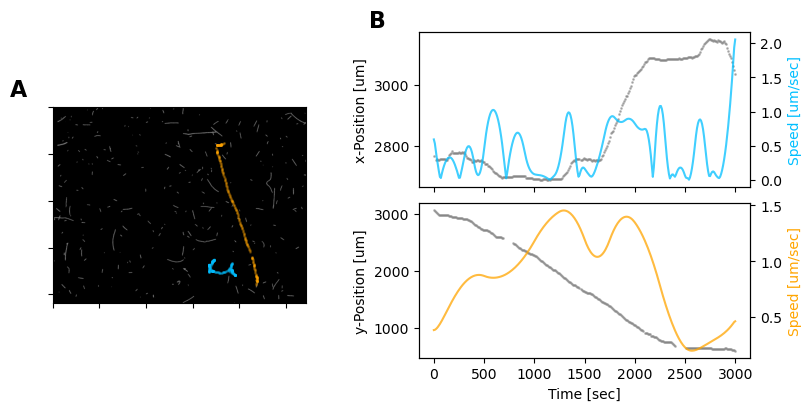

In [58]:
fig = plt.figure(layout='constrained', figsize=(8, 4))
subfigs = fig.subfigures(1, 2, wspace=0.1, width_ratios=[2/5,3/5])

axsLeftBot = subfigs[0].subplots(1, 1)
#subfigs[0].suptitle('Left plots', fontsize='x-large')
axsLeftBot.text(-0.1, 1.15, 'A', transform=axsLeftBot.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
axsLeftBot.imshow(frameB_thresholded,cmap='gray')
axsLeftBot.scatter(dat231[:,3],dat231[:,4],s=1,c='deepskyblue',marker='o',alpha=0.2)
axsLeftBot.scatter(dat106[:,3],dat106[:,4],s=1,c='orange',marker='o',alpha=0.2)
plt.setp(axsLeftBot.get_xticklabels(), visible=False)
plt.setp(axsLeftBot.get_yticklabels(), visible=False)

axsRightBot = subfigs[1].subplots(2, 1, sharex=True)
axsRightBot[0].text(-0.1, 1.15, 'B', transform=axsRightBot[0].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
#axsRightBot[0].scatter(frame_ids_231*dt, distC_231,marker='o',s=1,color='gray', alpha=0.5)  #actual centre distance to track end
#axsRightBot[0].plot(frame_ids_231*dt,centre_dist_fitted_231,color='k',alpha=0.25)  #spline for centre distance to track end
axsRightBot[0].scatter(frame_ids_231*dt, x_231,marker='o',s=1,color='gray', alpha=0.5)  #actual centre distance to track end
axsRightBot[0].set_ylabel('x-Position [um]',color='k',alpha=1)
ax0_2 = axsRightBot[0].twinx() 
ax0_2.plot(frame_ids_231*dt,np.abs(speedC_xy_231),color='deepskyblue',alpha=0.75)  #spline for centre speed (calculated from centre x-y)
ax0_2.set_ylabel('Speed [um/sec]',color='deepskyblue',alpha=1)

#axsRightBot[1].scatter(frame_ids_106*dt, distC_106,marker='o',s=1,color='gray', alpha=0.5)  #actual centre distance to track end
#axsRightBot[1].plot(frame_ids_106*dt,centre_dist_fitted_106,color='k',alpha=0.25)  #spline for centre distance to track end
axsRightBot[1].scatter(frame_ids_106*dt, y_106,marker='o',s=1,color='gray', alpha=0.5)  #actual centre distance to track end
axsRightBot[1].set_ylabel('y-Position [um]',color='k',alpha=1)
axsRightBot[1].set_xlabel('Time [sec]',color='k',alpha=1)
ax1_2 = axsRightBot[1].twinx() 
ax1_2.plot(frame_ids_106*dt,np.abs(speedC_xy_106),color='orange',alpha=0.75)  #spline for centre speed (calculated from centre x-y)
ax1_2.set_ylabel('Speed [um/sec]',color='orange',alpha=1)


fig.savefig(saveTrajFig)
fig.savefig(saveTrajFig2)
#plt.xscale('log')
plt.show()
plt.close(fig)